This tutorial uses the same example as the [example introduction](./example_introduction.ipynb).
In other words:

In [1]:
# Module we will use
import chaospy
import numpy
from matplotlib import pyplot

def model_predictor(coordinates, parameters):
    """Over simplistic model function."""
    param_I, param_a = parameters
    return param_I*numpy.e**(-param_a*coordinates)

# The spatio-temporal coordinates 
coordinates = numpy.linspace(0, 10, 1000)

# The distribution of the parameters
distribution_I = chaospy.Normal(1.5, 0.2)
distribution_a = chaospy.Uniform(0.1, 0.2)
distribution = chaospy.J(distribution_I, distribution_a)

## Point Collocation / Regression Method

Point collection method is a broad term, as it covers multiple approaches.
But in a nutshell:

* Generate $Q_1, ..., Q_N = (I_1, a_1), ..., (I_N, a_N)$, using (pseudo-)random samples or otherwise.
* Evaluate model predictor $U_1, ..., U_N$ for each sample.
* Select an expansion or polynomials $P_1, ..., P_M$, typically orthogonal (with respect to the probability distribution).
* Define the linear regression problem: $U_n = \sum_m c_m(t) P_m(I_n, a_n)$ and solve for $c_1, ..., c_M$.
* Analyze model approximation $u(I, a, t) = \sum_m c_m(t) P_n(I, a)$ instead of actual model solver. 

This approach does not require the samples to follow any distribution, nor does it require the polynomial expansion to have any particular properties, like e.g. orthogonality.
In practice however, when focusing on statistical properties (like mean and variance), it makes sense to have the number of samples in an area roughly proportional to the probability density function.
This can be achieved in a few ways, but most common is to either use random samples/low discrepancy sequences, or abscissas from a quadrature scheme.
And in the same way, even though the polynomials do not have to be orthogonal, in practice using orthogonal polynomials are shown to be more numerical stable.

Below, we will compare the [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence) and compare it to [optimal Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature).

### Generating samples

In chaospy, creating low-discrepancy sequences can be done using the `distribution.sample` method.
Creating quadrature points can be done using `chaospy.generate_quadrature`.

In [2]:
# Sampling schemes we want to include
rules = ["halton", "gaussian"]

# Generate samples for different orders:
samples = {"halton": distribution.sample((10+1)**2, rule="halton"),
           "gaussian": chaospy.generate_quadrature(10, distribution, rule="gaussian")[0]}

samples["halton"].shape, samples["gaussian"].shape

((2, 121), (2, 121))

The two schemes represents two different approaches.
One is meant to mimic random samples, while the other is designed for quadrature.

(array([[1.26993012, 1.23639782, 1.33389782, 1.0164882 , 1.30442049,
         1.22675924, 1.36014334],
        [0.14444444, 0.12962963, 0.19382716, 0.13950617, 0.11152263,
         0.18559671, 0.16090535]]),
 array([[0.46239976, 0.71276668, 1.124793  , 1.5       , 1.875207  ,
         2.28723332, 2.53760024],
        [0.10108857, 0.19435313, 0.17595481, 0.15      , 0.12404519,
         0.10564687, 0.19891143]]))

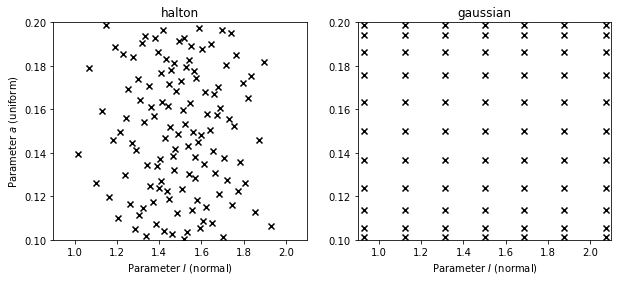

In [3]:
# increase figure width to better fit two plots
pyplot.rc("figure", figsize=[10, 4])

for idx, rule in enumerate(rules):
    pyplot.subplot(1, 2, idx+1)
    
    # Show samples as 2-dimensional scatter plot
    pyplot.scatter(*samples[rule], marker="x", color="k")
    
    # Make scatter ficutres pretty
    pyplot.xlabel("Parameter $I$ (normal)")
    pyplot.ylabel("Parameter $a$ (uniform)") if not idx else None
    pyplot.axis([0.9, 2.1, 0.1, 0.2])
    pyplot.title(rule)
    
samples["halton"][:, ::20], samples["gaussian"][:, ::20]

### Evaluating model predictor

Creating model predictions is fairly straight forward.
Just note that the (random) samples generated has shape `(dimensions, number_of_samples)`.
As such, it is important to transpose when iterating over samples.

In [4]:
# Evaluate model predictor for every sample
evaluations = {rule: numpy.array([model_predictor(coordinates, sample)
                                  for sample in samples[rule].T])
               for rule in rules}

evaluations["halton"].shape, evaluations["gaussian"].shape

((121, 1000), (121, 1000))

These model evaluations can be visualized, however ti is hard to observe the difference between the two schemes from these plots.

(array([[1.26993012, 1.26809527, 1.26626307, 1.26443351, 1.2626066 ],
        [1.46058018, 1.45908281, 1.45758697, 1.45609266, 1.45459989],
        [1.22675924, 1.22448225, 1.22220949, 1.21994094, 1.21767661]]),
 array([[0.46239976, 0.46193209, 0.4614649 , 0.46099818, 0.46053193],
        [1.3142262 , 1.31207735, 1.30993201, 1.30779018, 1.30565185],
        [2.28723332, 2.28481579, 2.28240082, 2.27998839, 2.27757852]]))

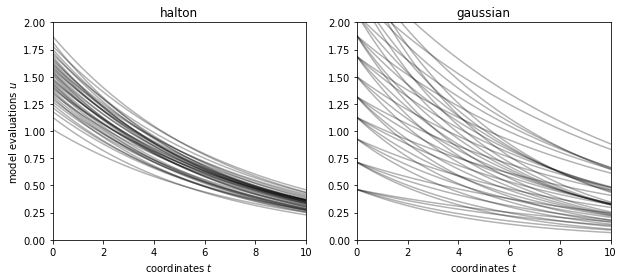

In [5]:
for idx, rule in enumerate(rules):
    pyplot.subplot(1, 2, idx+1)
    
    # Make a plot line for the first 50 evaluations
    for evals in evaluations[rule][::3]:
        pyplot.plot(coordinates, evals, "k-", alpha=0.3)
    
    # Make plot pretty
    pyplot.xlabel("coordinates $t$")
    pyplot.ylabel("model evaluations $u$") if not idx else None
    pyplot.title(rule)
    pyplot.axis([0, 10, 0, 2])
        
evaluations["halton"][::50, :5], evaluations["gaussian"][::50, :5]

### Select expansion of Polynomials

Creating polynomial expansion can be done using the _three terms recursion_ algorithm:

In [6]:
polynomial_order = 4
polynomial_expansion = chaospy.orth_ttr(polynomial_order, distribution)
polynomial_expansion[:6].round(5)

polynomial([1.0, -0.15+q1, -1.5+q0, 0.02167-0.3*q1+q1**2,
            0.225-1.5*q1-0.15*q0+q0*q1, 2.21-3.0*q0+q0**2])

Here the polynomials are function of two variables: $q_0, q_1$, which in the context of the order of `distribution` refer to respectively $I$ and $a$ in the original problem.

The created expansion is orthogonal with respect to each other in a weighted Hilbert space:

$$
    \langle \Phi_n, \Phi_m \rangle = \mathbb E[\Phi_n\Phi_m] = \delta_{nm} \|\Phi_n\|^2 \qquad
    \|\Phi_n\| = \sqrt{\langle\Phi_n, \Phi_n\rangle}
$$

where $\delta_{nm}$ is the Kronecker's delta.

In other words:

In [7]:
outer_product = chaospy.outer(polynomial_expansion[:6], polynomial_expansion[:6])
normed_inner_products = chaospy.E(outer_product, distribution) / chaospy.E(polynomial_expansion[:6]**2, distribution)
normed_inner_products.round(10)

array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -0.,  0.],
       [ 0.,  0.,  0., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

It is worth noting that scaling upwards, calculating $\mathbb E[\Phi_n^2]$ is known to tend to be numerically unstable.
It is more accurately calculated either using some quadrature scheme, or using the coefficients from the three terms recursion.
The latter can be retrieved by passing the flag `retall=True` to `chaospy.orth_ttr`.

In [8]:
_, norms = chaospy.orth_ttr(polynomial_order, distribution, retall=True)
norms[:4], chaospy.E(polynomial_expansion[:4]**2, distribution)

(array([1.00000000e+00, 8.33333333e-04, 4.00000000e-02, 5.55555556e-07]),
 array([1.00000000e+00, 8.33333333e-04, 4.00000000e-02, 5.55555556e-07]))

### Solve linear problem

With all samples $Q_1, ..., Q_N$, model evaluations $U_1, ..., U_N$ and polynomial expansion $\Phi_1, ..., \Phi_M$, we can put everything together to solve the equations:

$$
    U_n = \sum_{m=1}^M c_m(t) \Phi_m(Q_n) \qquad n = 1, ..., N
$$

with respect to the coefficients $c_1, ..., c_M$.

This can be done using the helper function `chaospy.fit_regression`:

In [9]:
model_approximations = {rule: chaospy.fit_regression(polynomial_expansion, samples[rule], evaluations[rule]) for rule in rules}
model_approximations["halton"][:5].round(3), model_approximations["gaussian"][:5].round(3)

(polynomial([q0, q0-0.01*q0*q1, q0-0.02*q0*q1, q0-0.03*q0*q1,
             q0-0.04*q0*q1+0.001*q0*q1**2]),
 polynomial([q0, q0-0.01*q0*q1, q0-0.02*q0*q1, q0-0.03*q0*q1,
             q0-0.04*q0*q1+0.001*q0*q1**2]))

This approximation can also be done manually, using the solution for least squares:

$$
    [\hat c_m]_m = \left([\Phi_m(Q_n)]_{mn}^T [\Phi_m(Q_n)]_{mn}\right)^{-1} [\Phi_m(Q_n)]_{mn}^T [U_n]_n
$$

Or using code:

In [10]:
phi = polynomial_expansion(*samples["halton"]).T
c_hat = numpy.linalg.inv(phi.T @ phi) @ (phi.T @ evaluations["halton"])
c_hat.shape

(15, 1000)

The coefficients can then be combined together with the original polynomial expansion:

In [11]:
alternative_approximation = chaospy.sum(c_hat.T*polynomial_expansion, axis=1).T
alternative_approximation[:5].round(3)

polynomial([q0, q0-0.01*q0*q1, q0-0.02*q0*q1, q0-0.03*q0*q1,
            q0-0.04*q0*q1+0.001*q0*q1**2])

### Assess Statistics



(array([1.5       , 1.4977495 , 1.4955025 , 1.493259  , 1.49101899]),
 array([0.04      , 0.03988025, 0.03976125, 0.03964299, 0.03952547]))

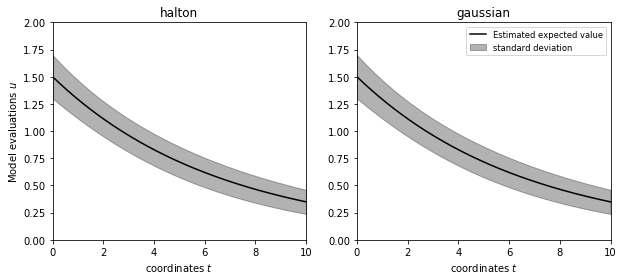

In [12]:
for idx, rule in enumerate(rules):
    pyplot.subplot(1, 2, idx+1)
    
    # Estimate mean and variance
    expected = chaospy.E(model_approximations[rule], distribution)
    variance = chaospy.Var(model_approximations[rule], distribution)

    # Create band one standard deviation away from mean 
    pyplot.fill_between(coordinates, expected-variance**0.5, expected+variance**0.5,
                        alpha=0.3, color="k", label="standard deviation")
    pyplot.plot(coordinates, expected, "k-", label="Estimated expected value")

    # Make plot pretty
    pyplot.xlabel("coordinates $t$")
    pyplot.axis([0, 10, 0, 2])
    pyplot.title(rule)
    pyplot.legend() if idx else pyplot.ylabel("Model evaluations $u$")
    
expected[:5], variance[:5]

### Error Analysis

It is hard to assess how well these models are doing from the final estimation alone.
They look about the same.
So to compare results, we do error analysis.
To do so, we use the reference analytical solution and error function as defined in the ``introduction``.

In [13]:
# True mean and variance (calculated analytically)
t = coordinates[1:]
true_mean = numpy.hstack([1.5, 15*(numpy.e**(-0.1*t)-numpy.e**(-0.2*t))/t])
true_variance = numpy.hstack([2.29, 11.45*(numpy.e**(-0.2*t)-numpy.e**(-0.4*t))/t])-true_mean**2

# Functions for estimate the distance between estimated and true statistics
error_mean = lambda mean: numpy.mean(numpy.abs(mean-true_mean))
error_variance = lambda variance: numpy.mean(numpy.abs(variance-true_variance))

To illustrate the difference in a common format, we plot error as a function of the number of samples used in a logarithmic plot.

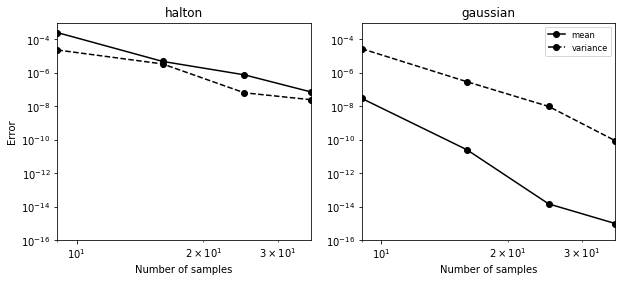

In [15]:
# Estimate mean and variance for various number of samples
polynomial_orders = list(range(2, 6))
for idx, rule in enumerate(rules):
    pyplot.subplot(1, 2, idx+1)
    
    results = []
    for order in polynomial_orders:
        
        # Perform analysis for a specific order
        samples = (distribution.sample((order+1)**2, rule="halton") if rule == "halton"
                   else chaospy.generate_quadrature(order, distribution, rule="gaussian")[0])
        evaluations = [model_predictor(coordinates, sample) for sample in samples.T]
        polynomial_expansion = chaospy.orth_ttr(order, distribution)
        model_approximation = chaospy.fit_regression(polynomial_expansion, samples, evaluations)
        
        # Store results 
        error_E = error_mean(chaospy.E(model_approximation, distribution))
        error_V = error_variance(chaospy.Var(model_approximation, distribution))
        results.append(((order+1)**2, error_E, error_V))
    
    # Extract results
    sizes, errors_E, errors_V = list(zip(*results))
    
    # Error plot for mean
    pyplot.loglog(sizes, errors_E, "ko-", label="mean")
    
    # Error plot for variance
    pyplot.loglog(sizes, errors_V, "ko--", label="variance")
    
    # Make plot pretty
    pyplot.axis([min(sizes), max(sizes), 1e-16, 1e-3])
    pyplot.title(rule)
    pyplot.xlabel("Number of samples")
    pyplot.legend() if idx else pyplot.ylabel("Error")

It is worth noting that Halton is not doing poorly, as much as the Gaussian approach doing so much better.
Though this can be the case some times, the effect most often drops drastically with the number of dimensions.